# Virtual Landmark

In [1]:
# import required modules
import matplotlib.pyplot as plt
import mediapipe as mp
import sys
import cv2
import os

#import the elements of this library
from virtual_landmark import (
    get_extended_pose_landmarks_style,
    VirtualLandmark,
    landmark,
    calculus as calc,
    Connections,
)

## Virtual Landmark 

The `HelloWorld` class extends `VirtualLandmark` and defines a set of custom virtual landmarks used for biomechanical or structural analysis of the human body, based on MediaPipe pose landmarks.

Each method decorated with `@landmark` computes a new point at the landmarks. Additionally, each landmark declares its visual or logical connections to other landmarks, enabling improved visualization and structural modeling.


In [2]:
class HelloWorld(VirtualLandmark):
    
    @landmark("MIDDLE_SHOULDER", connection=["RIGHT_SHOULDER", "LEFT_SHOULDER", "NECK"])
    def _middle_shoulder(self):
        return calc.middle(
            self[self.virtual_landmark.RIGHT_SHOULDER],
            self[self.virtual_landmark.LEFT_SHOULDER],
        )

    @landmark("NECK", connection=["MIDDLE_SHOULDER", "NOSE"])
    def _neck(self):
        return calc.middle(
            self[self.virtual_landmark.NOSE],
            self[self.virtual_landmark.MIDDLE_SHOULDER],
        )

    @landmark("MIDDLE_HIP", connection=["MIDDLE_SHOULDER", "LEFT_HIP", "RIGHT_HIP"])
    def _middle_hip(self):
        return calc.middle(
            self[self.virtual_landmark.LEFT_HIP],
            self[self.virtual_landmark.RIGHT_HIP],
        )

    @landmark("LEFT_RIB", connection=["LEFT_SHOULDER", "LEFT_HIP"])
    def _left_rib(self):
        return calc.middle(
            self[self.virtual_landmark.LEFT_HIP],
            self[self.virtual_landmark.LEFT_SHOULDER],
        )

    @landmark("RIGHT_RIB", connection=["RIGHT_SHOULDER", "RIGHT_HIP"])
    def _right_rib(self):
        return calc.middle(
            self[self.virtual_landmark.RIGHT_HIP],
            self[self.virtual_landmark.RIGHT_SHOULDER],
        )

    @landmark("THORAX", connection=["RIGHT_RIB", "LEFT_RIB", "MIDDLE_SHOULDER", "MIDDLE_HIP"])
    def _thorax(self): 
        return calc.middle(
            self[self.virtual_landmark.RIGHT_RIB],
            self[self.virtual_landmark.LEFT_RIB],
        )

## Process Image

Initializes the MediaPipe Pose solution, specifically configured for processing static images (e.g., photos or single frames).

- **`static_image_mode=True`**  
  Forces the model to run pose detection on every input image independently, without relying on temporal smoothing across frames. This is ideal for analyzing still images rather than video streams.

- **`model_complexity=2`**  
  Uses the most detailed and accurate version of the pose model. While it increases computational load, it provides higher precision in landmark detection—especially useful for complex or subtle body positions.

- **`enable_segmentation=False`**  
  Disables the segmentation mask feature, allowing the model to focus solely on detecting and returning pose landmarks. This reduces processing overhead when segmentation is not needed.

This configuration is well-suited for high-quality analysis of static poses, such as evaluating body posture in photos or generating virtual landmarks from single-frame input.

In [3]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=False)

I0000 00:00:1743888927.154709 15651366 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4


Before applying pose estimation, the input image must be properly loaded and formatted. Images read using OpenCV are represented in BGR color space by default, which is incompatible with many computer vision models—including MediaPipe Pose—that expect images in RGB format.

To ensure compatibility, the image is first loaded from a specified file path and then converted from BGR to RGB. This preprocessing step is essential for accurate landmark detection, as incorrect color formatting can significantly affect the performance of the pose estimation model.

In [4]:
image_path = "images/image-1.jpeg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Once the image has been properly formatted (in RGB color space), it can be passed into the pose estimation model.

The `process()` method analyzes the image and returns a structured result containing various outputs such as:

- **Pose landmarks**: 3D coordinates of detected body joints and keypoints.
- **Detection confidence scores**: Indicate how certain the model is about the detected landmarks.
- **(Optional) Segmentation masks**: If enabled, provide body segmentation (not used in this configuration).

This step represents the core inference process—where the machine learning model interprets the image and extracts meaningful pose data. The output is typically stored in a `results` object for further analysis, visualization, or custom landmark processing.

In [5]:
results = pose.process(image_rgb)

W0000 00:00:1743888927.212892 15651465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743888927.238289 15651465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743888927.286062 15651468 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


### Visualizing the Original and RGB Images

To better understand how image color formats affect processing, both the original image (in BGR) and its RGB-converted version are displayed side by side using Matplotlib.

- `plt.subplots(1, 2, figsize=(20, 10))`  
  Creates a single-row figure with two columns (subplots), large enough to clearly display the images.

- `axs[0].imshow(image)`  
  Displays the original image as loaded by OpenCV, which uses the **BGR color space**. As a result, colors may appear distorted (e.g., reds and blues may be swapped).

- `axs[1].imshow(image_rgb)`  
  Displays the same image after conversion to **RGB**, the correct format expected by most computer vision models and libraries (including MediaPipe and Matplotlib). Colors appear as intended.

- `axis("off")`  
  Hides axis ticks and labels for a cleaner visual comparison.

This visual comparison helps illustrate the importance of color space conversion when working with image processing libraries that have different color format conventions.

(-0.5, 2047.5, 2047.5, -0.5)

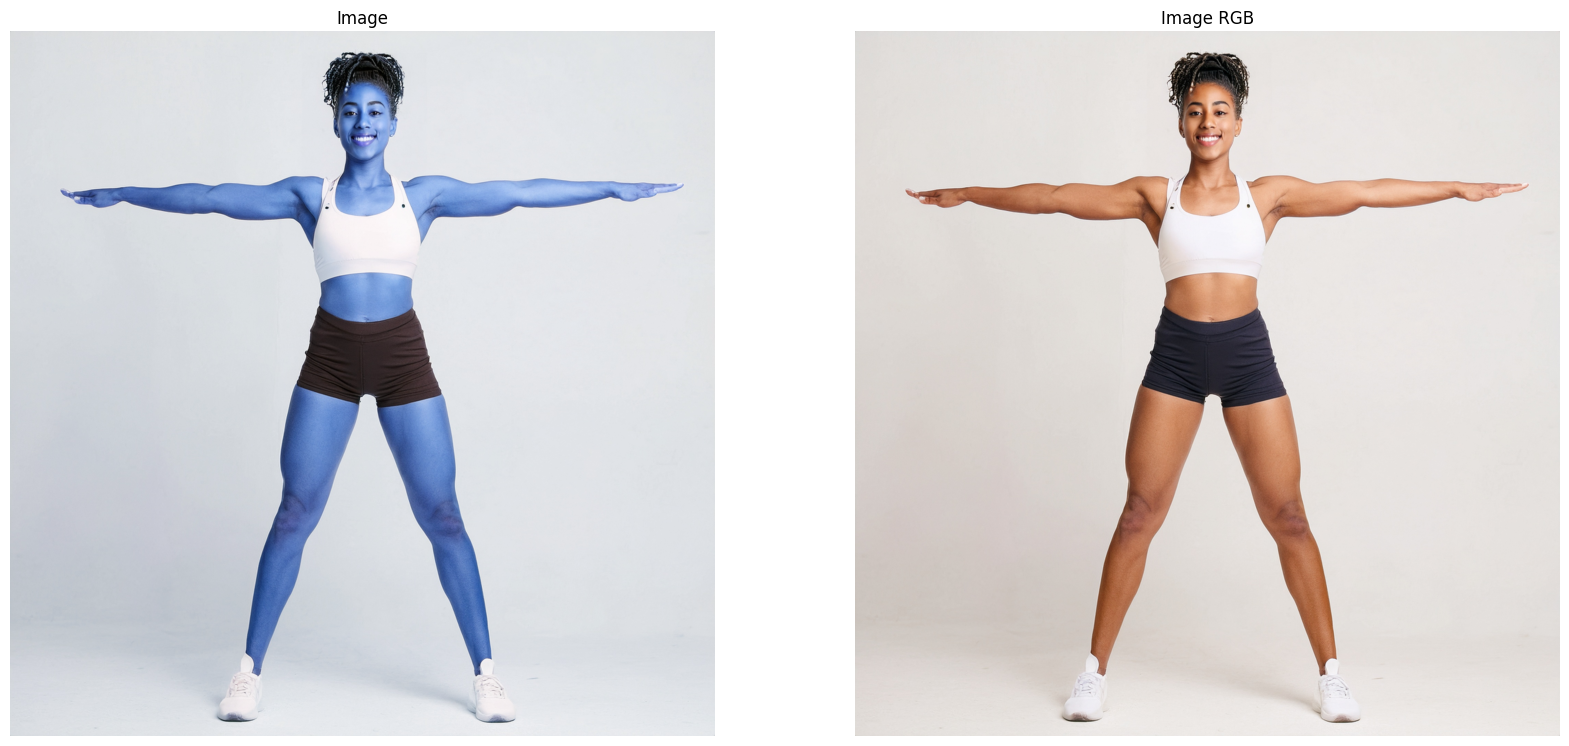

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(image)
axs[0].set_title("Image")
axs[0].axis("off")

axs[1].imshow(image_rgb)
axs[1].set_title("Image RGB")
axs[1].axis("off")

### Creating Virtual Landmarks and Custom Connections

After obtaining the raw pose landmarks from MediaPipe, the next step is to enrich this data with additional computed landmarks and define meaningful connections between them.

- **`landmarks = HelloWorld(results.pose_landmarks.landmark)`**  
  Instantiates the `HelloWorld` class with the list of detected landmarks.  
  This class extends the basic MediaPipe pose landmarks by introducing **virtual landmarks**—points that do not exist in the original model but are derived mathematically (e.g., midpoints like `MIDDLE_SHOULDER` or `THORAX`). These virtual points are useful for higher-level analysis, such as symmetry checks, pose classification, or biomechanical studies.

- **`connections = Connections(landmarks)`**  
  Builds a custom connection graph based on the extended set of landmarks.  
  It includes both original MediaPipe connections and new connections defined through decorators in the `HelloWorld` class. This structure can be used for visualizing the skeletal model, analyzing body segments, or computing angles between joints and virtual points.

Together, these two lines represent the bridge between raw pose estimation and structured, enriched pose analysis—enabling more advanced tasks like posture correction, motion assessment, or custom animations.

In [7]:
landmarks = HelloWorld(results.pose_landmarks.landmark)
connections = Connections(landmarks)

## Print Image with Landmakrs


MediaPipe provides built-in utilities to visualize landmarks and their connections directly on images. The `drawing_utils` module includes functions to:

- Draw individual pose landmarks with customizable styles.
- Render connections (e.g., bones or joints) between keypoints.
- Customize colors, thickness, and visibility for clear visual feedback.

By assigning `mp_drawing = mp.solutions.drawing_utils`, we create a shorthand reference to these tools, making it easier to call drawing functions later in the code. This is especially useful for overlaying pose annotations on top of the original or processed images.

In [8]:
mp_drawing = mp.solutions.drawing_utils

To visualize different sets of pose landmarks independently, a dictionary named `printable_images` is used. Each entry maps a descriptive label to a tuple containing:

1. A specific set of landmark connections (original, virtual, or combined).
2. A fresh copy of the input image to draw on.

- **`"Default Landmarks"`:**  Paired with `POSE_CONNECTIONS` to display only the original MediaPipe landmarks and their default skeletal connections.

- **`"Virtual Landmarks"`:**  Paired with `CUSTOM_CONNECTION` to show only the additional virtual landmarks defined in the `HelloWorld` class, such as anatomical midpoints.

- **`"All Landmarks":`**  Uses `ALL_CONNECTIONS` to render both original and virtual landmarks together, providing a complete view of the full pose structure.

This setup keeps each visualization isolated and focused, making it ideal for comparison, debugging, or presentation purposes.

In [9]:
printable_images = {
    "Default Landmarks": (connections.POSE_CONNECTIONS,  image_rgb.copy()),
    "Virtual Landmarks": (connections.CUSTOM_CONNECTION, image_rgb.copy()),
    "All Landmarks":     (connections.ALL_CONNECTIONS,   image_rgb.copy()),
}

Before rendering the pose landmarks, a consistent visual style is defined:

- **`color = (255, 255, 255)`:** Sets the connection lines to white for clear visibility on most image backgrounds.
- **`thickness = 2`:** Specifies the line thickness used when drawing connections between landmarks.
- **`landmarks_style = get_extended_pose_landmarks_style(landmarks)`** Generates a custom drawing specification for each landmark, possibly differentiating between original and virtual points with unique colors or sizes. Then, using a loop over the `printable_images` dictionary, the code draws pose landmarks and their respective connections onto each image.
- **`landmark_list=landmarks.as_landmark_list()`:** Converts the enriched landmark structure (including virtual points) into a format compatible with MediaPipe's drawing utilities.
- **`connections=value[0]`:** Uses the appropriate connection set (original, virtual, or all) based on the current image context.
- **`image=value[1]`:** Draws directly onto the image copy associated with the given connection type.

This approach ensures a uniform and automated rendering pipeline for all three visualizations, keeping the output clean and comparable.

In [10]:
color = (255,255,255)
thickness = 2
landmarks_style = get_extended_pose_landmarks_style(landmarks)

for value in printable_images.values():
    mp_drawing.draw_landmarks(
        image=value[1],
        landmark_list=landmarks.as_landmark_list(),  
        connections=value[0],  
        landmark_drawing_spec=landmarks_style,
        connection_drawing_spec=mp_drawing.DrawingSpec(color=color, thickness=thickness),
    )


To compare the different sets of pose landmarks, the annotated images are displayed side by side using Matplotlib:

- **`plt.subplots(1, 3, figsize=(24, 10))`:** Creates a figure with one row and three columns, each sized large enough to clearly show detailed landmark drawings.
- **Loop over `printable_images.items()`:** Iterates through each labeled image, dynamically assigning:
  - `title`: the label (e.g., "Default Landmarks")
  - `image`: the corresponding annotated image
- **`axs[idx].imshow(image)`:** Displays the current image in the appropriate subplot.
- **`axs[idx].set_title(title)`:** Adds a title above each image for context.
- **`axs[idx].axis("off")`:** Hides axis ticks and borders to create a cleaner, image-focused layout.
- **`plt.tight_layout()`:** Automatically adjusts spacing between subplots to prevent overlap or clipping.
- **`plt.show()`:** Renders the complete figure.

This structured layout provides a clear and immediate visual comparison between the original, virtual, and combined landmark sets—making it ideal for analysis, presentations, or debugging.

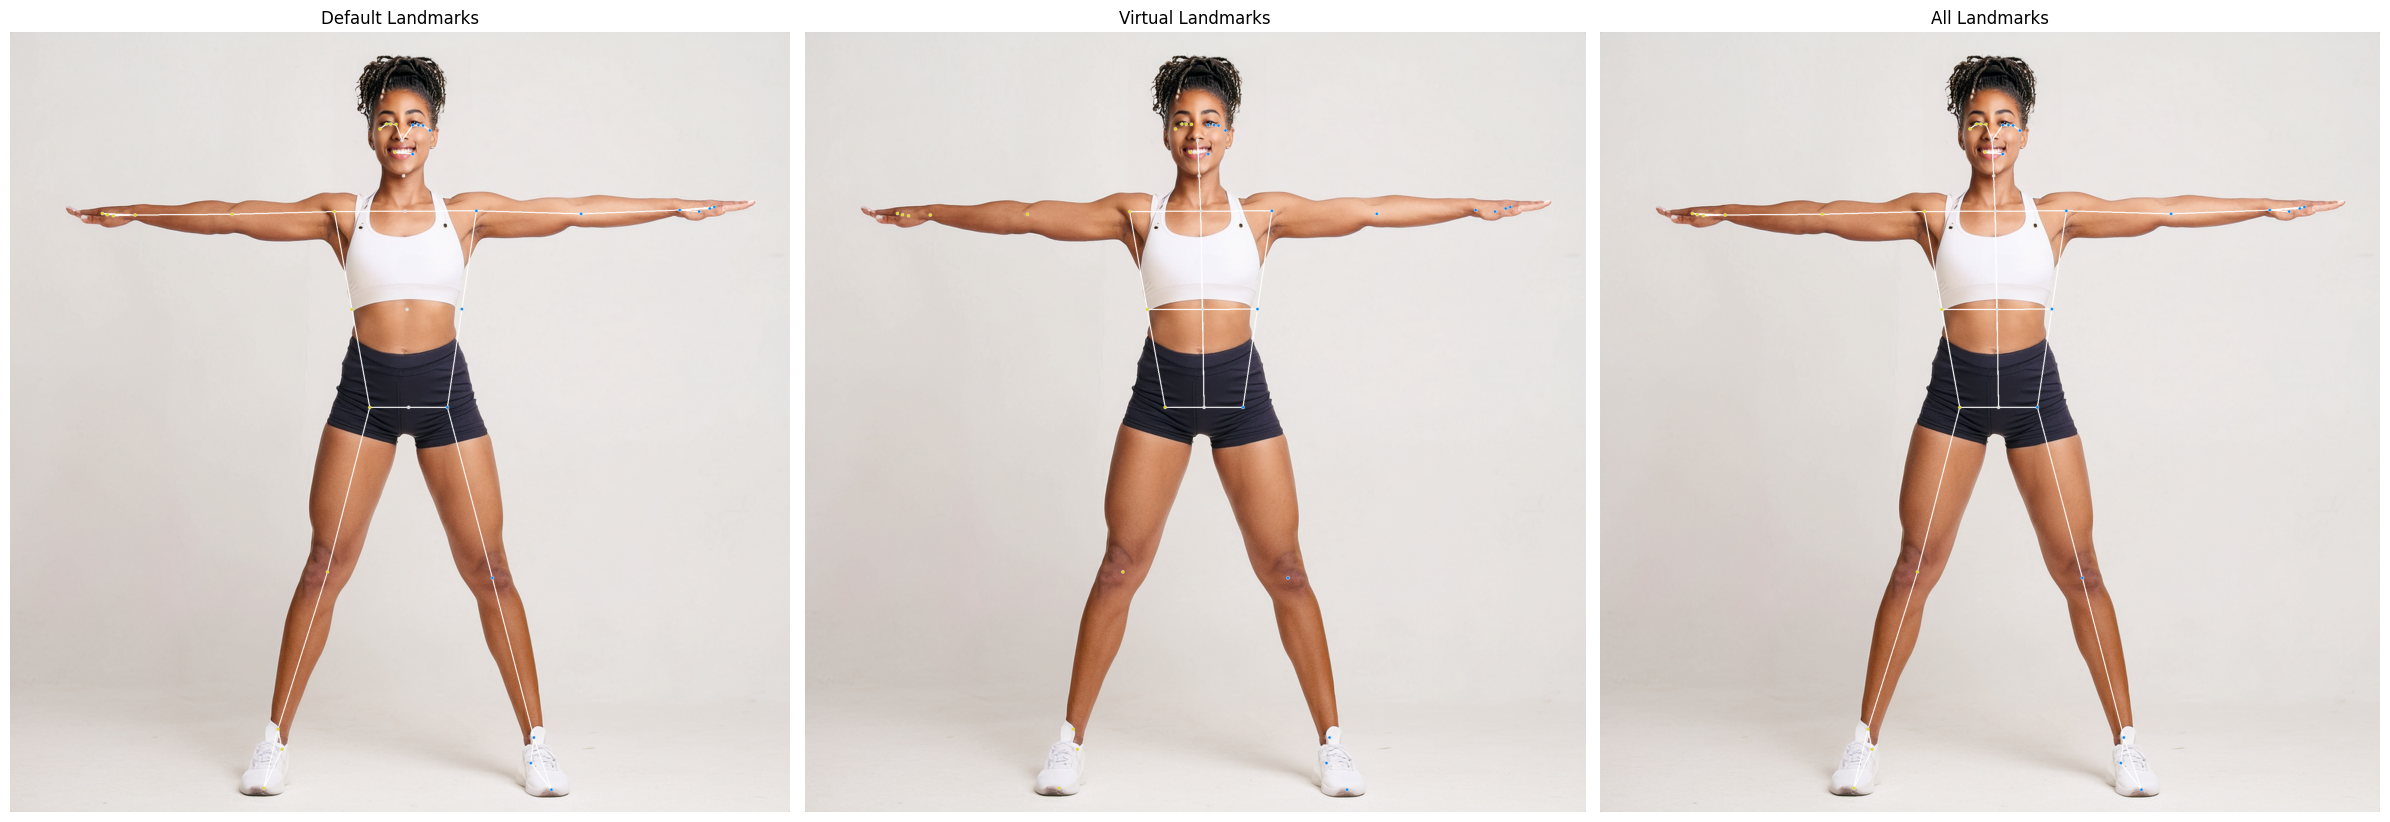

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(24, 10))

for idx, (title, (_, image)) in enumerate(printable_images.items()):
    axs[idx].imshow(image)
    axs[idx].set_title(title)
    axs[idx].axis("off")

plt.tight_layout()
plt.show()